# Artificial Intelligence & Robotics
## *Predicting churn in the telecommunication sector*

This Notebook is the product of an academic work for course [Artificial Intelligence & Robotics](https://kursuskatalog.cbs.dk/2019-2020/KAN-CINTO1820U.aspx), held at Copenhagen Business School during spring 2020.

<br>

*Course professors*

Daniel Hardt

Kim Normann Andersen

<br>

*Notebook authors*

Edoardo Abate

Michele Scarperi




In [15]:
# In this notebook we make use of mglearn for plotting graphs. It might be needed to install mglearn using pip.
 !pip install mglearn

     |████████████████████████████████| 542kB 3.4MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.7-py2.py3-none-any.whl size=582705 sha256=a251358f5abf6f7fe6936082fa7b7952acbc224df28539afb28000870aa4ed70
  Stored in directory: /root/.cache/pip/wheels/74/cf/8d/04f4932d15854a36726c6210763c7127e62de28f5c8ddfcf3b
Successfully built mglearn


## 1. First look at the dataset

###  Load Telco Customer Churn Data
Notice that the dataset can be retrieved at https://www.kaggle.com/blastchar/telco-customer-churn/data

In [0]:
import pandas as pd
import numpy as np

In [3]:
# Make sure the dataset is nested within folder "Data"
df = pd.read_csv("Data/Telco-Customer-Churn.csv", index_col=0)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Initial reflections  
The dataset contains a total of 20 features. Most of the feature columns are of type "Object" as they contain strings. They are *all* of categorical nature, and 12 of them are boolean categories (Yes/No). 

Three columns are of numerical nature `SeniorCitizen`(int64), `tenure`(int64) `MonthlyCharges`(float64). Surprisingly, `TotalCharges` is not a *float64* like `MonthlyCharges`, but an Object. We will investigate this further later on in this Notebook.

In [4]:
#There are no NAs. "count" returns 7043 for all features
df.isna().sum() 

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### A more in-depth look at string features
We now want to understand the value structure of each string feature. We want to get an overview of:
- (1) the amount of unique values for each string feature; 
- (2) the unique values for each string feature.
Some of them are structured in a binary way. We can easily one hot encode these features using a single additional column.

Some other features present more categories, and they will have to be handled different. One hot enconding them will yield creating one additional column per unique value.

In [5]:
# We want to understand which string attributes are binary, which are of a higher category order
for col in df: 
    if df.dtypes[col]==np.object: # We disregard numerical attributes and only take a look at objects
        print(col,'(', len(df[col].unique()), ' unique values): ', df[col].unique(),'\n') 
        

gender ( 2  unique values):  ['Female' 'Male'] 

Partner ( 2  unique values):  ['Yes' 'No'] 

Dependents ( 2  unique values):  ['No' 'Yes'] 

PhoneService ( 2  unique values):  ['No' 'Yes'] 

MultipleLines ( 3  unique values):  ['No phone service' 'No' 'Yes'] 

InternetService ( 3  unique values):  ['DSL' 'Fiber optic' 'No'] 

OnlineSecurity ( 3  unique values):  ['No' 'Yes' 'No internet service'] 

OnlineBackup ( 3  unique values):  ['Yes' 'No' 'No internet service'] 

DeviceProtection ( 3  unique values):  ['No' 'Yes' 'No internet service'] 

TechSupport ( 3  unique values):  ['No' 'Yes' 'No internet service'] 

StreamingTV ( 3  unique values):  ['No' 'Yes' 'No internet service'] 

StreamingMovies ( 3  unique values):  ['No' 'Yes' 'No internet service'] 

Contract ( 3  unique values):  ['Month-to-month' 'One year' 'Two year'] 

PaperlessBilling ( 2  unique values):  ['Yes' 'No'] 

PaymentMethod ( 4  unique values):  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Cre

## 2. Pre-processing

### Pre-processing string features
Some features present three unique values such as "Yes", "No" and "No internet service". We argue that "No internet service" can be merged into "No" with little harm done to the overall information. For the sake of integrity, we can save the information that the customer has "no internet service" in a new, additional, column. 


We now proceed with replacing value "No internet service" with "No" for a variety of columns.
For the same reason, value "No phone service" for feature `MultipleLines` is replaced with "No".


We use the dataframe method `replace()` to accomplish this.

In [6]:
# For the following list of features, we want to replace "No internet service" with "No"
featuresToProcess = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Replace "No internet service" with "No" for all of the above features
for feature in featuresToProcess:
    df = df.replace({feature: 'No internet service'}, 'No')

# Replace "No phone service" with "No" for attribute 'MultipleLines'
df = df.replace({'MultipleLines': 'No phone service'}, 'No')

# We check whether those attributes now present 2 unique values
for col in df: 
    if df.dtypes[col]==np.object: # Again, we disregard numerical attributes
        print(col,'(', len(df[col].unique()), ' unique values): ', df[col].unique(),'\n') 

gender ( 2  unique values):  ['Female' 'Male'] 

Partner ( 2  unique values):  ['Yes' 'No'] 

Dependents ( 2  unique values):  ['No' 'Yes'] 

PhoneService ( 2  unique values):  ['No' 'Yes'] 

MultipleLines ( 2  unique values):  ['No' 'Yes'] 

InternetService ( 3  unique values):  ['DSL' 'Fiber optic' 'No'] 

OnlineSecurity ( 2  unique values):  ['No' 'Yes'] 

OnlineBackup ( 2  unique values):  ['Yes' 'No'] 

DeviceProtection ( 2  unique values):  ['No' 'Yes'] 

TechSupport ( 2  unique values):  ['No' 'Yes'] 

StreamingTV ( 2  unique values):  ['No' 'Yes'] 

StreamingMovies ( 2  unique values):  ['No' 'Yes'] 

Contract ( 3  unique values):  ['Month-to-month' 'One year' 'Two year'] 

PaperlessBilling ( 2  unique values):  ['Yes' 'No'] 

PaymentMethod ( 4  unique values):  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 

TotalCharges ( 6531  unique values):  ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5'] 

Churn ( 2  unique values):  

### Pre-processing binary features
The next step is to *one-hot* encode binary features. We make us of `get_dummies()` and a small function written by us, `boolify()`, to create new columns in the dataset.

For each binary feature, we generate a single `bool` column. Value "`Yes`" is cast into `1`, while "`No`" is cast into `0`.

Feature `gender` is handled in a similar way, though the generated `boolMale` column simply  represents "`Male`" as `1` and "`Female`" as `0`.

In [7]:
# Our boolify() takes a dataframe and a column as input, returns the same dataset with a new column, 
# where the input column is encoded with binary values.
def boolify(dataframe, columns):
    boolDataframe = dataframe; #Instantiate the input dataframe locally
    for columnName in columns:
        oneHotColumns = pd.get_dummies(dataframe[columnName])
        oneHotColumns = oneHotColumns.drop('No', axis = 1) # We are only interested in keeping the "Yes"
        oneHotColumns = oneHotColumns.rename(columns={"Yes": "bool"+columnName}, errors="raise")
        boolDataframe = boolDataframe.join(oneHotColumns) # We add the binary column to the input dataframe
    return boolDataframe


# We first turn binary columns into one hot encoded columns
df = boolify(df, ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn'])


# We turn "gender" column into a boolean one hot encoded column 'boolMale'
oneHotColumns = pd.get_dummies(df['gender'])
oneHotColumns = oneHotColumns.drop('Female',axis = 1)
oneHotColumns = oneHotColumns.rename(columns={"Male": "boolMale"}, errors="raise")
df = df.join(oneHotColumns)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,boolPartner,boolDependents,boolPhoneService,boolMultipleLines,boolOnlineSecurity,boolOnlineBackup,boolDeviceProtection,boolTechSupport,boolStreamingTV,boolStreamingMovies,boolPaperlessBilling,boolChurn,boolMale
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0,0,0,0,1,0,0,0,0,1,0,0
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,0,0,1,0,1,0,1,0,0,0,0,0,1
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0,0,1,0,1,1,0,0,0,0,1,1,1
7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,0,0,0,1,0,1,1,0,0,0,0,1
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,0,1,0,0,0,0,0,0,0,1,1,0


### Pre-processing string features with multiple values
Columns `InternetService`, `Contract` and `PaymentMethod` present multiple unique values. We generate *one-hot encoded* columns for each unique value, for all three features.

The *one-hot* encoded columns are then added to the already processed dataframe.

In [0]:
# We one hot encode column "InternetService"
oneHotColumns = pd.get_dummies(df['InternetService'], prefix='boolInternetService')
df = df.join(oneHotColumns)

# We one hot encode column "Contract"
oneHotColumns = pd.get_dummies(df['Contract'], prefix='boolContract')
df = df.join(oneHotColumns)

# We one hot encode column "PaymentMethod"
oneHotColumns = pd.get_dummies(df['PaymentMethod'], prefix='boolPaymentMethod')
df = df.join(oneHotColumns)

### Fixing feature `TotalCharges`

As previously noticed, `TotalCharges` is of type Object instead of Float64.
We first tried to conver it to `float` using astype(). However, this throws an exception.

We therefore try to figure out what values are causing this issue. According to StackOverflow, this is most likely caused by a whitespaces.

In [9]:
# Using `df["TotalCharges"] = df["TotalCharges"].astype(float)` throws an exception
validValues = 0
notNumericValues = []
for string in df['TotalCharges']:
    if " " in string:
        notNumericValues.append(string)
        
print("Found (",len(notNumericValues),") whitespaces")
print(notNumericValues)

Found ( 11 ) whitespaces
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


We drop (11) rows with whitespaces entries for `TotalCharges`. Then, we can finally convert `TotalCharges` to float

In [10]:
df = df[df["TotalCharges"]!= " "]
df = df.reset_index()[df.columns]

# We can finally convert TotalCharges to float
df["TotalCharges"] = df["TotalCharges"].astype(float)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 43 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   gender                                       7032 non-null   object 
 1   SeniorCitizen                                7032 non-null   int64  
 2   Partner                                      7032 non-null   object 
 3   Dependents                                   7032 non-null   object 
 4   tenure                                       7032 non-null   int64  
 5   PhoneService                                 7032 non-null   object 
 6   MultipleLines                                7032 non-null   object 
 7   InternetService                              7032 non-null   object 
 8   OnlineSecurity                               7032 non-null   object 
 9   OnlineBackup                                 7032 non-null   object 
 10  

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,boolPartner,boolDependents,boolPhoneService,boolMultipleLines,boolOnlineSecurity,boolOnlineBackup,boolDeviceProtection,boolTechSupport,boolStreamingTV,boolStreamingMovies,boolPaperlessBilling,boolChurn,boolMale,boolInternetService_DSL,boolInternetService_Fiber optic,boolInternetService_No,boolContract_Month-to-month,boolContract_One year,boolContract_Two year,boolPaymentMethod_Bank transfer (automatic),boolPaymentMethod_Credit card (automatic),boolPaymentMethod_Electronic check,boolPaymentMethod_Mailed check
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0,0,1,0,1,1,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0


### Normalizing numerical features
Columns `tenure`, `MonthlyCharges` and `TotalCharges` contain numbers. It is good practice to squash their values between 0 and 1, as this will reduce training time for our models later on.


In [11]:
# We get all the numerical features
data = df.select_dtypes(np.number)
data.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,boolPartner,boolDependents,boolPhoneService,boolMultipleLines,boolOnlineSecurity,boolOnlineBackup,boolDeviceProtection,boolTechSupport,boolStreamingTV,boolStreamingMovies,boolPaperlessBilling,boolChurn,boolMale,boolInternetService_DSL,boolInternetService_Fiber optic,boolInternetService_No,boolContract_Month-to-month,boolContract_One year,boolContract_Two year,boolPaymentMethod_Bank transfer (automatic),boolPaymentMethod_Credit card (automatic),boolPaymentMethod_Electronic check,boolPaymentMethod_Mailed check
0,0,1,29.85,29.85,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,0,1,0,1,1,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1
3,0,45,42.30,1840.75,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0
4,0,2,70.70,151.65,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0


In [12]:
def normalizeColumn(dataframe, columns):
    for column in columns:
        minVal = data[column].min()
        maxVal = data[column].max()
        dataframe[column] = ( dataframe[column] - minVal ) / (maxVal - minVal)
    return dataframe;

data = normalizeColumn(data, ["tenure", "MonthlyCharges", "TotalCharges"])
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,boolPartner,boolDependents,boolPhoneService,boolMultipleLines,boolOnlineSecurity,boolOnlineBackup,boolDeviceProtection,boolTechSupport,boolStreamingTV,boolStreamingMovies,boolPaperlessBilling,boolChurn,boolMale,boolInternetService_DSL,boolInternetService_Fiber optic,boolInternetService_No,boolContract_Month-to-month,boolContract_One year,boolContract_Two year,boolPaymentMethod_Bank transfer (automatic),boolPaymentMethod_Credit card (automatic),boolPaymentMethod_Electronic check,boolPaymentMethod_Mailed check
0,0,0.000000,0.115423,0.001275,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0.464789,0.385075,0.215867,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
2,0,0.014085,0.354229,0.010310,0,0,1,0,1,1,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1
3,0,0.619718,0.239303,0.210241,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0
4,0,0.014085,0.521891,0.015330,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0


## EDA

### Principal Component Analysis (PCA)

In [13]:
# We separate features from target
y = data["boolChurn"]
X = data.drop('boolChurn', axis = 1)

print(X.shape)
print(y.shape)

(7032, 26)
(7032,)


Original shape: (7032, 26)
Reduced shape: (7032, 2)


Text(0, 0.5, 'Second principal component')

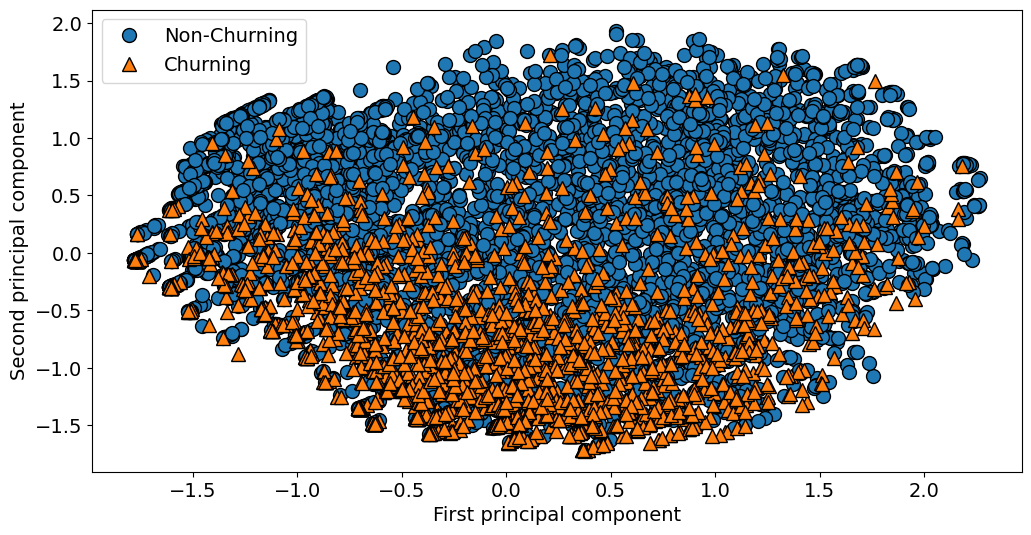

In [25]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import mglearn

pca = PCA(n_components=2).fit(X)


X_pca = pca.transform(X)
print("Original shape: {}".format(str(X.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

plt.style.use("default")
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 6))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], y)
plt.legend(["Non-Churning", "Churning"], loc="best")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

The two classes overlap a lot in the two-dimensional space plotted using the top two principal components. 

We now compute histograms of each of the features for the two classes, *Churning* and *Non-Churning*, to check whether any feature manages to tell them apart.

For `bool` features, we correctly see discrete values, either `0` or `1`.

<Figure size 640x480 with 0 Axes>

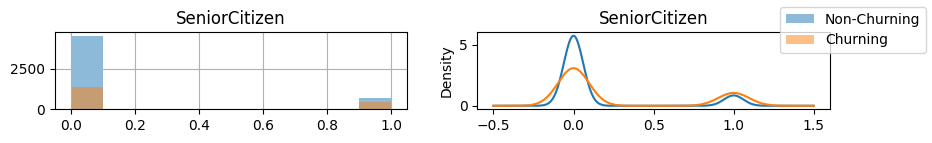

<Figure size 640x480 with 0 Axes>

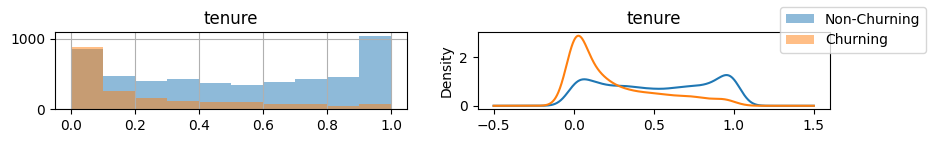

<Figure size 640x480 with 0 Axes>

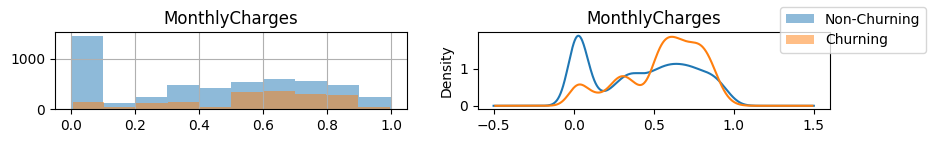

<Figure size 640x480 with 0 Axes>

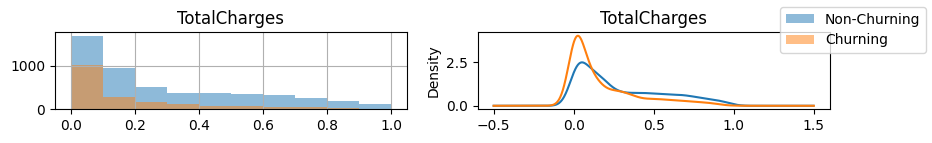

<Figure size 640x480 with 0 Axes>

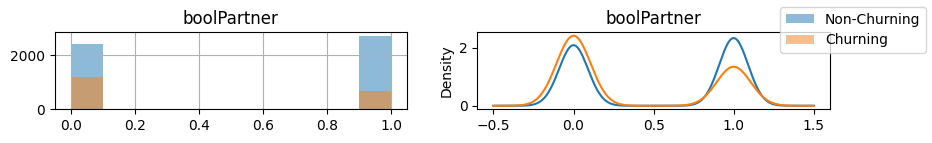

<Figure size 640x480 with 0 Axes>

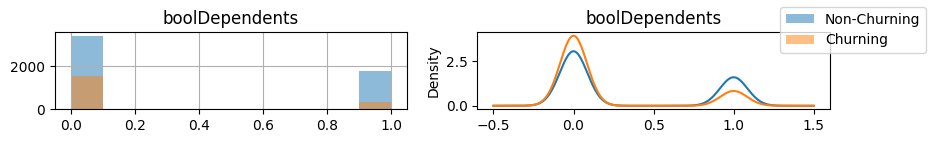

<Figure size 640x480 with 0 Axes>

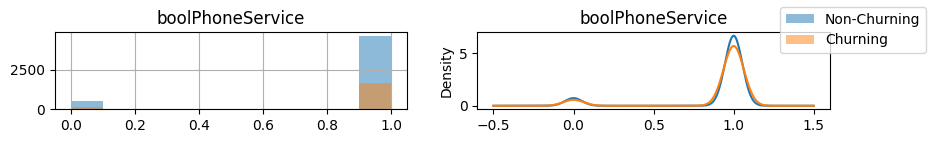

<Figure size 640x480 with 0 Axes>

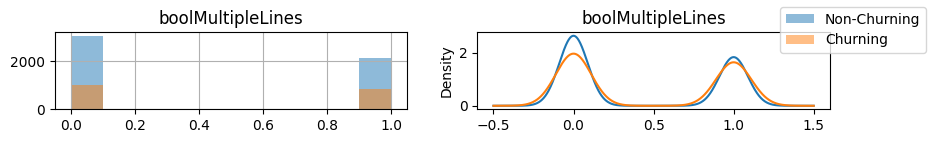

<Figure size 640x480 with 0 Axes>

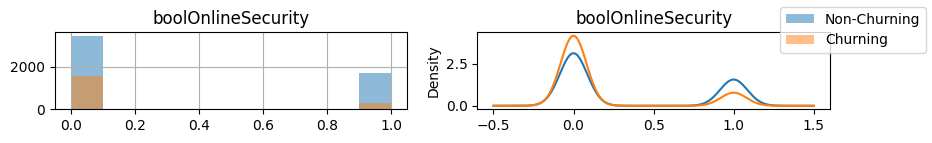

<Figure size 640x480 with 0 Axes>

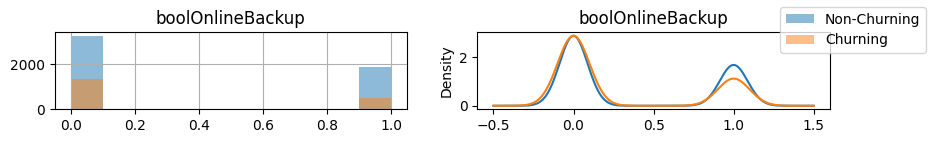

<Figure size 640x480 with 0 Axes>

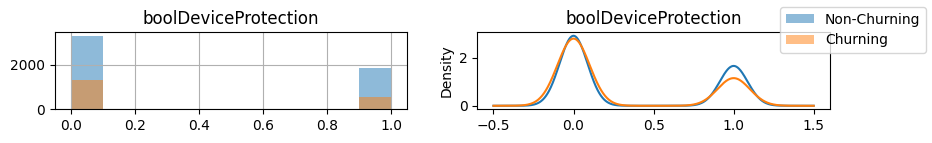

<Figure size 640x480 with 0 Axes>

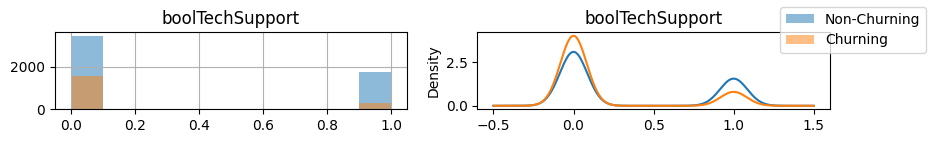

<Figure size 640x480 with 0 Axes>

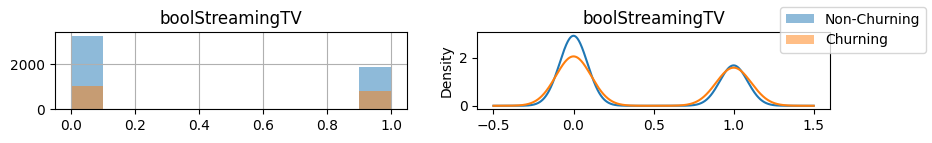

<Figure size 640x480 with 0 Axes>

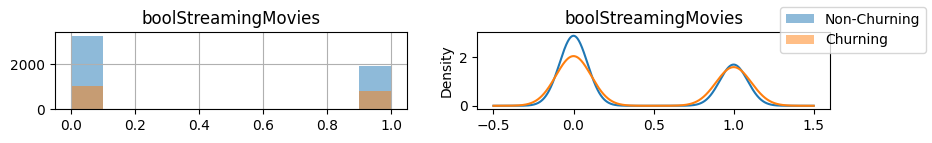

<Figure size 640x480 with 0 Axes>

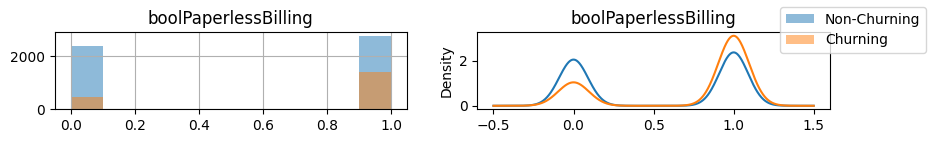

<Figure size 640x480 with 0 Axes>

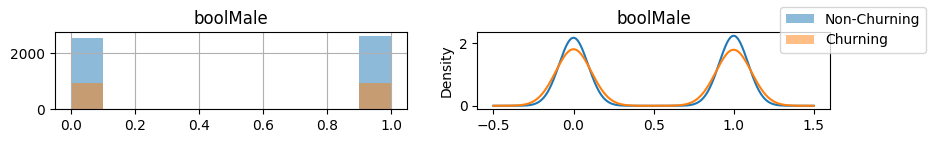

<Figure size 640x480 with 0 Axes>

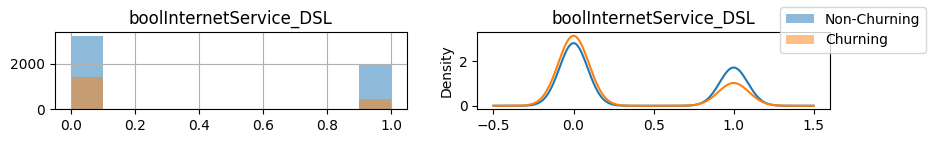

<Figure size 640x480 with 0 Axes>

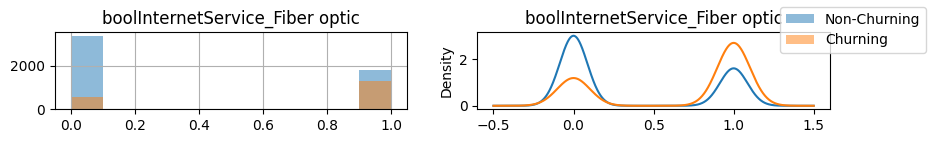

<Figure size 640x480 with 0 Axes>

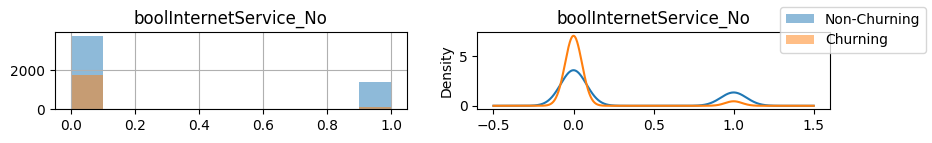

<Figure size 640x480 with 0 Axes>

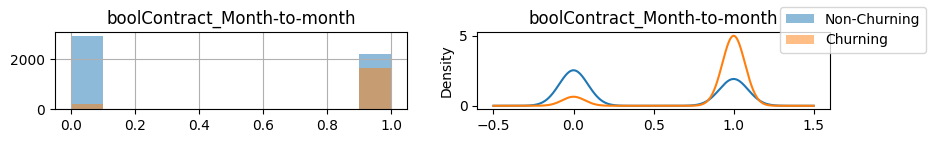

<Figure size 640x480 with 0 Axes>

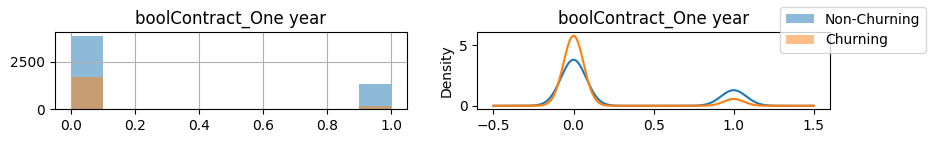

<Figure size 640x480 with 0 Axes>

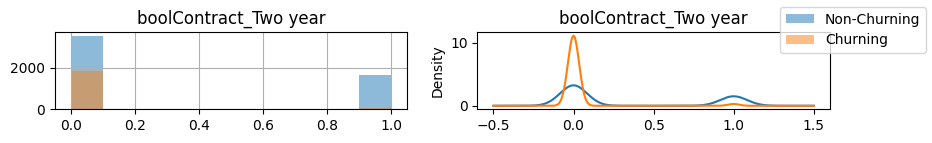

<Figure size 640x480 with 0 Axes>

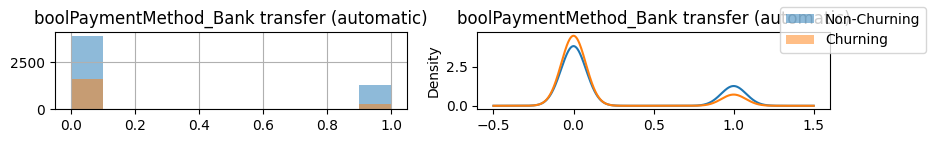

<Figure size 640x480 with 0 Axes>

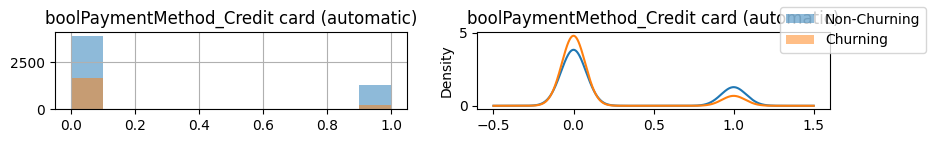

<Figure size 640x480 with 0 Axes>

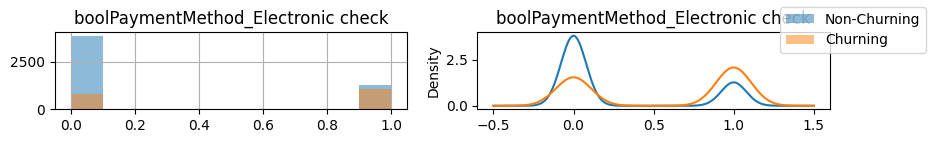

<Figure size 640x480 with 0 Axes>

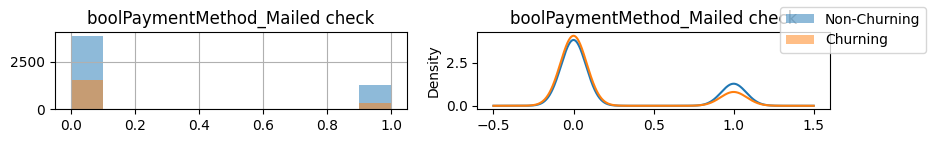

In [0]:
# We get the list of pre-processed features
features = X.columns

for feature in features:
  plt.clf()
  fig, axs = plt.subplots(ncols=2, figsize=(10, 1))
  data.groupby("boolChurn")[feature].plot(kind='kde', ax=axs[1])
  data.groupby("boolChurn")[feature].hist(alpha=0.5, ax=axs[0])
  axs[0].set_title(feature)
  axs[1].set_title(feature)
  fig.legend(["Non-Churning","Churning"])
  plt.show()
  

No feature allows to tell the classes apart. However, we can notice some interesting patterns. 

Churning happens almost exclusively when the contract type is month-to-month, as opposed to longer formats.

Customers are equally likely to churn, independently of the gener.

A more in depth visualization of the features against the target classes is available in the *EDA_In_Depth* Notebook. We recommend checking it out.

Finally, we compute correlation for each feature against target classes.

We use the correlation to define an alternative version of the feature dataset, where the amount of features is limited to the ten most correlated features with the target.

In [0]:
churn_corr = df.corr()['boolChurn']
correlatedFeatures = churn_corr.abs().sort_values(ascending=False)[1:]
correlatedFeatures

boolContract_Month-to-month 0.40456455007784087
tenure 0.3540493589532604
boolInternetService_Fiber optic 0.30746259069818205
boolContract_Two year 0.30155233962397837
boolPaymentMethod_Electronic check 0.30145463790858057
boolInternetService_No 0.22757762044656818
TotalCharges 0.19948408356757072
MonthlyCharges 0.19285821847008583
boolPaperlessBilling 0.19145432108006671
boolContract_One year 0.17822502328994053
boolOnlineSecurity 0.17126992353351678
boolTechSupport 0.16471590834411207
boolDependents 0.16312843938822
SeniorCitizen 0.1505410534156757
boolPartner 0.14998192562006138
boolPaymentMethod_Credit card (automatic) 0.1346868372340906
boolInternetService_DSL 0.12414142842590645
boolPaymentMethod_Bank transfer (automatic) 0.1181359978280296
boolPaymentMethod_Mailed check 0.09077284582582087
boolOnlineBackup 0.08230696876508349
boolDeviceProtection 0.06619251684228997
boolStreamingTV 0.06325398027519404
boolStreamingMovies 0.06085993668146301
boolMultipleLines 0.040032739872523634

In [0]:
X_reduced = pd.DataFrame()
max_features = 10; # We are going to use the top 10 correlated features from the previous computation

for feature, correlation in  list(correlatedFeatures.items())[:max_features]:
  X_reduced[feature] = X[feature]

# We get an overview of the "reduced" X dataframe
print(X_reduced.info())
X_reduced.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   boolContract_Month-to-month         7032 non-null   uint8  
 1   tenure                              7032 non-null   float64
 2   boolInternetService_Fiber optic     7032 non-null   uint8  
 3   boolContract_Two year               7032 non-null   uint8  
 4   boolPaymentMethod_Electronic check  7032 non-null   uint8  
 5   boolInternetService_No              7032 non-null   uint8  
 6   TotalCharges                        7032 non-null   float64
 7   MonthlyCharges                      7032 non-null   float64
 8   boolPaperlessBilling                7032 non-null   uint8  
 9   boolContract_One year               7032 non-null   uint8  
dtypes: float64(3), uint8(7)
memory usage: 213.0 KB
None


,boolContract_Month-to-month,tenure,boolInternetService_Fiber optic,boolContract_Two year,boolPaymentMethod_Electronic check,boolInternetService_No,TotalCharges,MonthlyCharges,boolPaperlessBilling,boolContract_One year
0,1,0.000000,0,0,1,0,0.001275,0.115423,1,0
1,0,0.464789,0,0,0,0,0.215867,0.385075,0,1
2,1,0.014085,0,0,0,0,0.010310,0.354229,1,0
3,0,0.619718,0,0,0,0,0.210241,0.239303,0,1
4,1,0.014085,1,0,1,0,0.015330,0.521891,1,0


## 3. Models evaluation
In this section, we evaluate the performance of various *machine learning* models, as well as a small *neural network*.

To do so, we first define training and a test data from the previously pre-processed dataset. We initially try to train the models with all the features. In a subsequent iteration, we evaluate the models by limiting the features to the top 10 correlated ones.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5625, 26) (5625,)
(1407, 26) (1407,)


### Evaluation without feature selection

The models we evaluate are: 
- K-NN Classifier
- Support Vector Classifier (SVC)
- Logistic Regression Classifier
- Random Forest Classifier
- Naive Bayes Classifier.

For each classifier, we run a Grid Search with cross-validation. After a first Grid Search, we plot the runs using a function written by us `plotGridSearchRuns()` to keep the code more clean.

`plotGridSearchRuns()` visualizes a heat-map with all the runs of cross-validation, with a particular
parameter setting. Cross-validation accuracy is encoded with color. The lighter the color, the higher the accuracy.  It allows us to optimize the region searched for the various parameters.

`plotGridSearchRuns()` can only plot two parameters from the parameter grid, since it would become troublesome to visualize more than three dimensions (the three dimensions being the two parameters and the accuracy).

#### Classifiers list

In [0]:
from sklearn.model_selection import GridSearchCV

# We define a table that will hold the best scores and hyperparam settings for each tested model
modelsScores = pd.DataFrame(columns=["Model","Best hyperparameter settings", "Train Score (F1)", "Test Score (F1)"])
modelsScores.set_index('Model')

# The following simply generalize our GridSearchCV code, so that future sections are easier to read
def runGridSearch(model, param_grid, cv=5, n_jobs=-1,):
  global grid_search
  grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='f1', n_jobs=n_jobs)
  grid_search.fit(X_train, y_train)
  print('Test set score: {:.4f}'.format(grid_search.score(X_test, y_test)))
  print('Best parameters: {}'.format(grid_search.best_params_))
  print('Best cross-validation score: {:.4f}'.format(grid_search.best_score_))
  # Save the scores and hyperparams for the model


# Notice that the following function only supports two input parameters.
# It would become troublesome to visualize more than three dimensions (the two parameters and the accuracy)
import mglearn

def plotGridSearchRuns(firstParam, secondParam, cmap='viridis'):
  results = pd.DataFrame(grid_search.cv_results_)
  scores = np.array(results.mean_test_score).reshape(len(param_grid[firstParam]), len(param_grid[secondParam]))
  mglearn.tools.heatmap(scores, xlabel=secondParam, xticklabels=param_grid[secondParam],
  ylabel=firstParam, yticklabels=param_grid[firstParam], cmap=cmap)
  


#### k-Nearest Neighbors (k-NN)

In [0]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [1, 5, 10, 15],
    'weights': ['uniform', 'distance']
}


runGridSearch(KNeighborsClassifier(), param_grid)
plotGridSearchRuns('n_neighbors', 'weights')

Test set score: 0.5543
Best parameters: {'n_neighbors': 15, 'weights': 'uniform'}
Best cross-validation score: 0.5633


Test set score: 0.5833
Best parameters: {'n_neighbors': 40, 'weights': 'uniform'}
Best cross-validation score: 0.5859


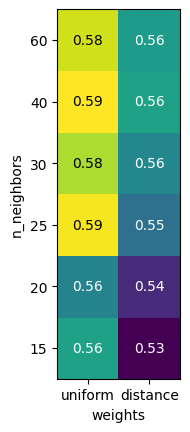

In [0]:
param_grid = {'n_neighbors': [15, 20, 25, 30, 40, 60],
'weights': ['uniform', 'distance']}


runGridSearch(KNeighborsClassifier(), param_grid)
plotGridSearchRuns('n_neighbors', 'weights')

#### Naive Bayes Classifier

Test set score: 0.6089
Best parameters: {'alpha': 1, 'fit_prior': False}
Best cross-validation score: 0.6178


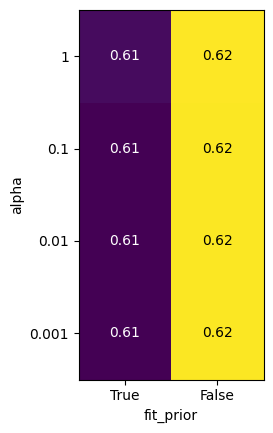

In [0]:
from sklearn.naive_bayes import MultinomialNB

param_grid = {'alpha': [0.001, 0.01, 0.1, 1],
'fit_prior': [True, False]}

runGridSearch(MultinomialNB(), param_grid)
plotGridSearchRuns('alpha', 'fit_prior')

Test set score: 0.6089
Best parameters: {'alpha': 1, 'fit_prior': False}
Best cross-validation score: 0.6178


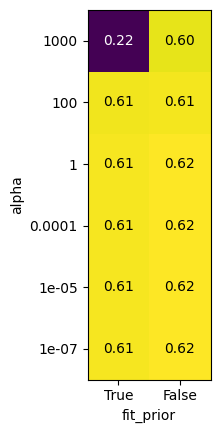

In [0]:
param_grid = {'alpha': [1e-07, 1e-05, 0.0001, 1, 100, 1000],
'fit_prior': [True, False]}

runGridSearch(MultinomialNB(), param_grid)
plotGridSearchRuns('alpha', 'fit_prior')

#### Logistic Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test set score: 0.5988
Best parameters: {'C': 100, 'solver': 'saga'}
Best cross-validation score: 0.6024


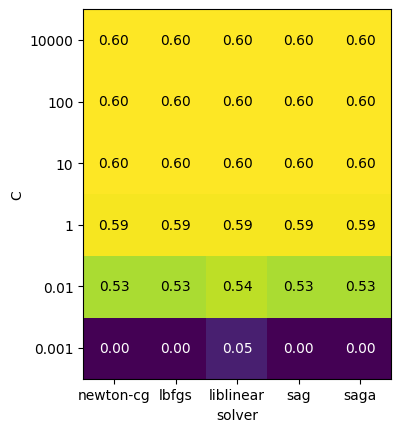

In [0]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.001, 0.01, 1, 10, 100, 10000],
'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

runGridSearch(LogisticRegression(), param_grid)

plotGridSearchRuns('C', 'solver')

Test set score: 0.6000
Best parameters: {'C': 1000, 'max_iter': 40000, 'solver': 'liblinear'}
Best cross-validation score: 0.6015


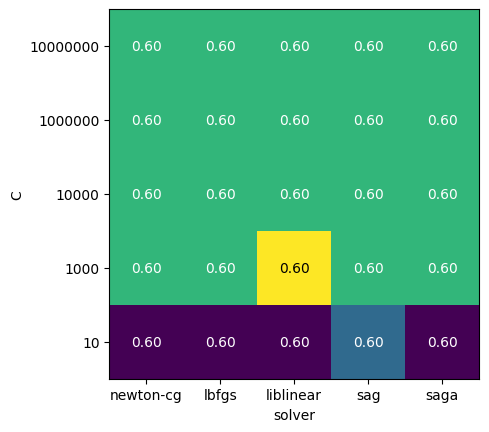

In [0]:
param_grid = {'C': [10, 1000, 10000, 1000000, 10000000],
'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
'max_iter': [40000]} # We are setting `max_iter` to avoid "convergence warning"

runGridSearch(LogisticRegression(), param_grid)

plotGridSearchRuns('C', 'solver')

#### Linear Support Vector Machines (Linear SVC)

Test set score: 0.5750
Best parameters: {'C': 10, 'tol': 1}
Best cross-validation score: 0.5940


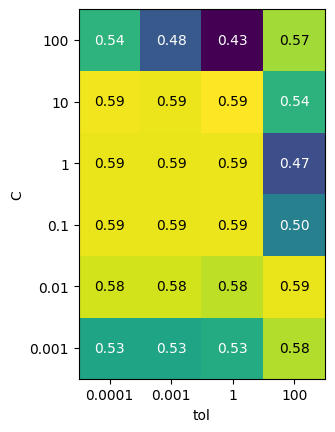

In [0]:
from sklearn.svm import LinearSVC

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
'tol': [1e-4, 0.001, 1, 100]}


runGridSearch(LinearSVC(), param_grid)
plotGridSearchRuns('C', 'tol')


Test set score: 0.5802
Best parameters: {'C': 0.1, 'max_iter': 10000, 'tol': 1}
Best cross-validation score: 0.5981


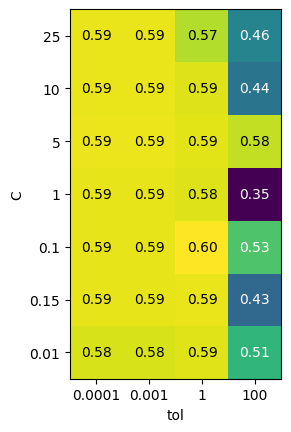

In [0]:
param_grid = {'C': [0.01, 0.15, 0.1, 1, 5, 10, 25],
'tol': [1e-4, 0.001, 1, 100],
'max_iter': [10000]
}


runGridSearch(LinearSVC(), param_grid)
plotGridSearchRuns('C', 'tol')


#### Random Forest Classifier

Test set score: 0.5539
Best parameters: {'max_features': 10, 'n_estimators': 100}
Best cross-validation score: 0.5617


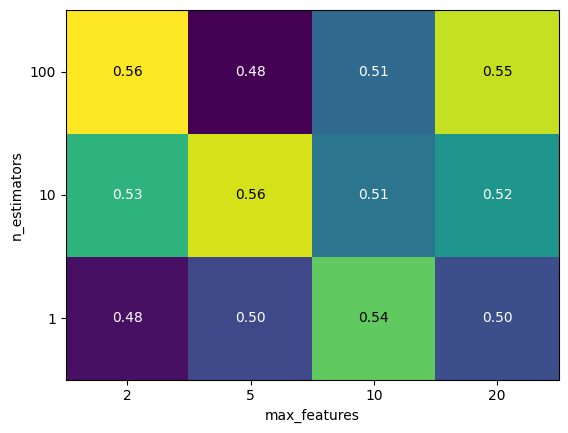

In [0]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [1, 10, 100],
'max_features': [2, 5, 10, 20]}


runGridSearch(RandomForestClassifier(), param_grid)
plotGridSearchRuns('n_estimators', 'max_features')

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Test set score: 0.5229
Best parameters: {'max_features': 10, 'n_estimators': 50}
Best cross-validation score: 0.5593


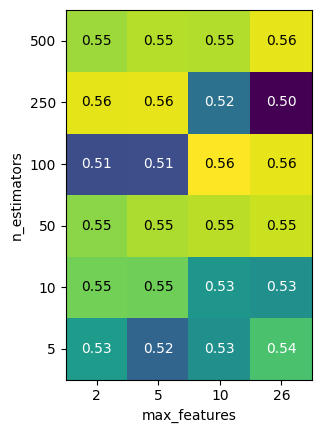

In [0]:
param_grid = {'n_estimators': [5, 10, 50, 100, 250, 500],
'max_features': [2, 5, 10, len(X.columns)]
}

runGridSearch(RandomForestClassifier(), param_grid)

plotGridSearchRuns('n_estimators', 'max_features')

#### Support Vector Classifier (SVC)

Test set score: 0.5873
Best parameters: {'C': 100, 'gamma': 0.001}
Best cross-validation score: 0.5882


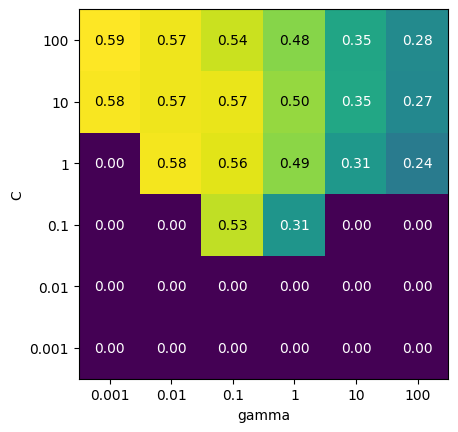

In [0]:
from sklearn.svm import SVC

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}


runGridSearch(SVC(), param_grid)
plotGridSearchRuns('C', 'gamma')

Test set score: 0.5873
Best parameters: {'C': 100, 'gamma': 0.001}
Best cross-validation score: 0.5882


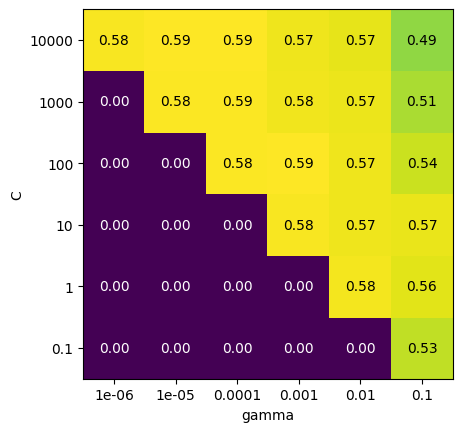

In [0]:
param_grid = {'C': [1, 10, 100, 1000, 10000],
'gamma': [1e-06, 1e-05, 1e-04, 0.001, 0.01, 0.1]}

runGridSearch(SVC(), param_grid)
plotGridSearchRuns('C', 'gamma')

#### Deep Learning model

#### Multi-Layer Perceptron (MLP)

Test set score: 0.5896
Best parameters: {'activation': 'relu', 'batch_size': 50, 'hidden_layer_sizes': (5, 5), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'sgd'}
Best cross-validation score: 0.5872


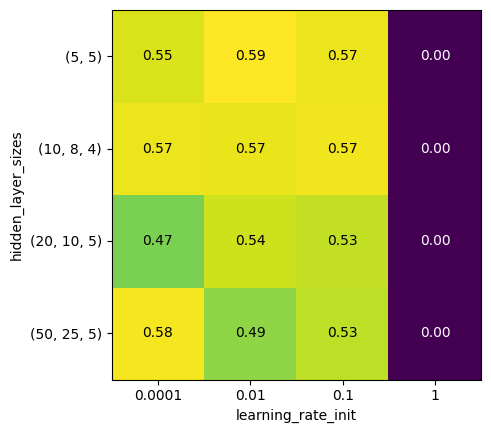

In [0]:
from sklearn.neural_network import MLPClassifier


param_grid = {
            'activation' : ['relu'],
            'solver' : ['sgd'],
            'hidden_layer_sizes': [
              (50,25,5,),
              (20,10,5,),
              (10,8,4,),
              (5,5,)
            ],
            'learning_rate_init': [0.0001, 0.01, 0.1, 1],
            'learning_rate' :['adaptive'],
            'max_iter': [200],
            'batch_size': [50]
        }
       

NN = MLPClassifier(random_state=0)

runGridSearch(NN, param_grid)
plotGridSearchRuns('hidden_layer_sizes', 'learning_rate_init')

Test set score: 0.5896
Best parameters: {'activation': 'relu', 'batch_size': 50, 'hidden_layer_sizes': (5, 5), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'sgd'}
Best cross-validation score: 0.5872


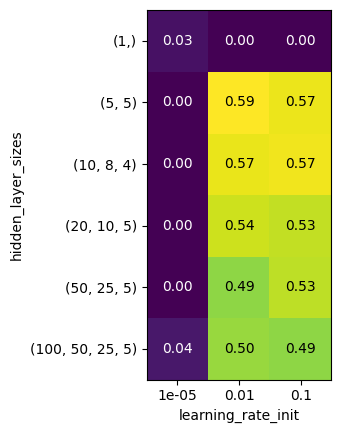

In [0]:
param_grid = {
            'activation' : ['relu'],
            'solver' : ['sgd'],
            'hidden_layer_sizes': [
              (100,50,25,5,),
              (50,25,5,),
              (20,10,5,),
              (10,8,4,),
              (5,5,),
              (1,)
            ],
            'learning_rate_init': [0.001, 0.01, 0.1],
            'learning_rate' :['adaptive'],
            'max_iter': [200],
            'batch_size': [50]
        }
       

NN = MLPClassifier(random_state=0)

runGridSearch(NN, param_grid)
plotGridSearchRuns('hidden_layer_sizes', 'learning_rate_init')

In [0]:
from fastai.tabular import *

'SeniorCitizen'

In [0]:
dep_var='boolChurn'
cat_names = X.columns
procs = [FillMissing, Categorify, Normalize]

databunch = (TabularList.from_df(data, cat_names=cat_names, procs=procs).split_by_idx(valid_idx=range(800,1000)).label_from_df(cols=dep_var).databunch())

databunch.classes

[0, 1]

In [0]:
learn = tabular_learner(databunch, layers=[200,100],  metrics=accuracy)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.462387,0.424018,0.780000,00:03


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


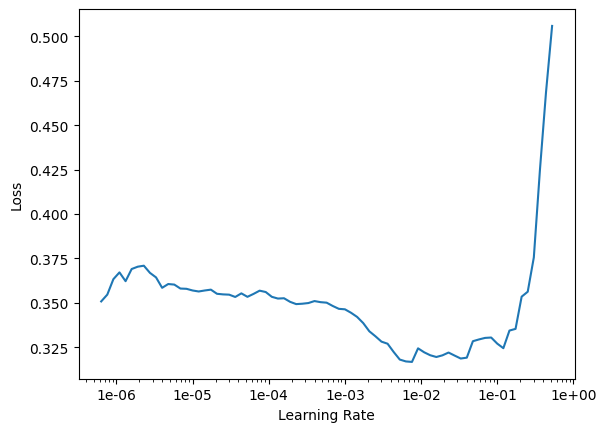

In [0]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

## Evaluation with feature selection


Now, we seek to evaluate whether a selection of the computed features has an impact in the performance of the various models.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5625, 10) (5625,)
(1407, 10) (1407,)


Test set score: 0.5612
Best parameters: {'C': 1, 'solver': 'liblinear'}
Best cross-validation score: 0.5864


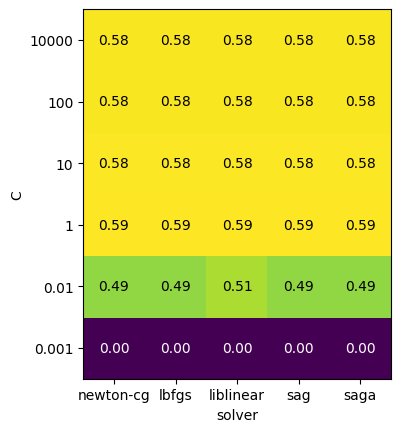

In [0]:
param_grid = {'C': [0.001, 0.01, 1, 10, 100, 10000],
'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

runGridSearch(LogisticRegression(), param_grid)

plotGridSearchRuns('C', 'solver')